# Определение перспективного тарифа для телеком-компании

**Цель исследования** — проанализировать поведение клиентов и сделать вывод — какой тариф лучше для компании.

# Описание данных 

Согласно документации к данным:<br><br>
Таблица users (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана <br><br>
Таблица calls (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок<br><br>
Таблица messages (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение<br><br>
Таблица internet (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя<br><br>
Таблица tariffs (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Обзор данных #

In [51]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
from math import ceil
from matplotlib import pyplot as plt

In [52]:
try:
    calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date']) # чтение файла с данными и сохранение в calls
except:
    calls = pd.read_csv('C:\\Users\\User\\Downloads\\calls.csv', parse_dates=['call_date'])

In [53]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [54]:
display(calls.head(3))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


В таблице calls 202607 строк. Нулевых значений нет. В столбце call_date меняем тип данных на дату.

In [55]:
try:
    internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date']) 
    # чтение файла с данными и сохранение в internet
except:
    internet = pd.read_csv('C:\\Users\\User\\Downloads\\internet.csv', parse_dates=['session_date'])

In [56]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [57]:
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


В таблице 149396 строк, нулевых значений нет. Необходимо удалить столбец Unnamed: 0. Он не заявлен в документации. 

In [58]:
try:
    messages = pd.read_csv('/datasets/messages.csv',parse_dates=['message_date']) 
    # чтение файла с данными и сохранение в messages
except:
    messages = pd.read_csv('C:\\Users\\User\\Downloads\\messages.csv', parse_dates=['message_date'])

In [59]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [60]:
messages.head(3)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


В таблице 123036 строк, нулевых значений нет. При чтении сразу переводим столбец message_date в даты.

In [61]:
try:
    tariffs = pd.read_csv('/datasets/tariffs.csv') # чтение файла с данными и сохранение в tariffs
except:
    tariffs = pd.read_csv('C:\\Users\\User\\Downloads\\tariffs.csv')

In [62]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [63]:
try:
    users = pd.read_csv('/datasets/users.csv', parse_dates=['reg_date','churn_date']) 
    # чтение файла с данными и сохранение в users
except:
    users = pd.read_csv('C:\\Users\\User\\Downloads\\users.csv', parse_dates=['reg_date','churn_date'])

In [64]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [65]:
users.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


Есть пропуски в столбце churn_date - это дата прекращения пользования тарифом. (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

## Предобработка данных

In [66]:
internet = internet.drop(columns=['Unnamed: 0']) # удаляем столбец

In [67]:
# Добавляем столбец month для расчета количества сделанных звонков и израсходованных минут разговора по месяцам.
calls['month'] = calls['call_date'].dt.month 

In [68]:
# Добавляем столбец month для расчета количества отправленных сообщений по месяцам.
messages['month'] = messages['message_date'].dt.month 

In [69]:
# Добавляем столбец month для расчета объема израсходованного интернет-трафика по месяцам.
internet['month'] = internet['session_date'].dt.month 

Расчет длительности и количества звонков каждого пользователя по месяцам.

In [70]:
calls['duration'] = np.ceil(calls['duration']) # округление продолжительности звонка в большую сторону

In [71]:
# сводная таблица с длительностью и количеством звонков
calls_per_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']) 
calls_per_month.columns=['calls_count', 'calls_duration'] # переименовываем столбцы
calls_per_month

calls_count  calls_duration
user_id month                             
1000    5               22           159.0
        6               43           172.0
        7               47           340.0
        8               52           408.0
        9               58           466.0
...                    ...             ...
1498    10              41           247.0
1499    9                9            70.0
        10              68           449.0
        11              74           612.0
        12              69           492.0

[3174 rows x 2 columns]

Расчет использованных мегабайт по каждому пользователю помесячно.

In [72]:
# сводная таблица с количеством использованным мб помесяцам
mb_used_per_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum') 
mb_used_per_month.columns=['mb_used_sum']    # переименовываем столбцы
mb_used_per_month['mb_used_sum'] = np.ceil(mb_used_per_month['mb_used_sum']) # округление использованного трафика 
                                                                                      # в большую сторону
mb_used_per_month

mb_used_sum
user_id month             
1000    5           2254.0
        6          23234.0
        7          14004.0
        8          14056.0
        9          14569.0
...                    ...
1498    10         20580.0
1499    9           1846.0
        10         17789.0
        11         17964.0
        12         13056.0

[3203 rows x 1 columns]

Расчет количества сообщений по каждому пользователю помесячно.

In [73]:
messages_per_month = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_per_month.columns=['messages_count']
messages_per_month

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

Для вычисления помесячной выручки соединим в одну таблицу предыдущие расчеты.

In [74]:
users_pivot = calls_per_month.join([mb_used_per_month, messages_per_month])
users_pivot

calls_count  calls_duration  mb_used_sum  messages_count
user_id month                                                          
1000    5             22.0           159.0       2254.0            22.0
        6             43.0           172.0      23234.0            60.0
        7             47.0           340.0      14004.0            75.0
        8             52.0           408.0      14056.0            81.0
        9             58.0           466.0      14569.0            57.0
...                    ...             ...          ...             ...
1498    10            41.0           247.0      20580.0            42.0
1499    9              9.0            70.0       1846.0            11.0
        10            68.0           449.0      17789.0            48.0
        11            74.0           612.0      17964.0            59.0
        12            69.0           492.0      13056.0            66.0

[3174 rows x 4 columns]

Добавим в таблицу название тарифа.

In [75]:
users_pivot = users_pivot.join(users.loc[:,['user_id', 'tariff']].set_index('user_id'))

In [76]:
users_pivot

calls_count  calls_duration  mb_used_sum  messages_count tariff
user_id month                                                                 
1000    5             22.0           159.0       2254.0            22.0  ultra
        6             43.0           172.0      23234.0            60.0  ultra
        7             47.0           340.0      14004.0            75.0  ultra
        8             52.0           408.0      14056.0            81.0  ultra
        9             58.0           466.0      14569.0            57.0  ultra
...                    ...             ...          ...             ...    ...
1498    10            41.0           247.0      20580.0            42.0  smart
1499    9              9.0            70.0       1846.0            11.0  smart
        10            68.0           449.0      17789.0            48.0  smart
        11            74.0           612.0      17964.0            59.0  smart
        12            69.0           492.0      13056.0            66.0  smart

[3174 rows x 5 columns]

In [77]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [78]:
users_pivot.isnull().sum() # проверим количество пропущенных значений в users_pivot

calls_count         0
calls_duration      0
mb_used_sum        11
messages_count    496
tariff              0
dtype: int64

Считаем, что пропущенные значения означают, что пользователь не ипользовал услуги, поэтому заменяем их на нули.

In [79]:
users_pivot.fillna(0, inplace=True)
users_pivot.isnull().sum() # заменяем пропуски на нули

calls_count       0
calls_duration    0
mb_used_sum       0
messages_count    0
tariff            0
dtype: int64

Добавляем в таблицу название города.

In [80]:
users_pivot = users_pivot.join(users.loc[:,['user_id', 'city']].set_index('user_id'), how='outer')

Создаем функцию для расчета помесячной выручки с каждого пользователя.

In [81]:
def total_income_per_month_calculation(row):
    calls_count = row['calls_count'] 
    calls_duration = row['calls_duration']
    mb_used_sum = row['mb_used_sum']
    messages_count = row['messages_count']
    tariff = row['tariff']
    
    # переменные стоимости и лимитов для каждого из тарифов.
    megabytes_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['mb_per_month_included'])  
    messages_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['messages_included'])
    minutes_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['minutes_included'])
    monthly_fee = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_monthly_fee'])
    price_for_gb = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_gb'])
    price_for_message = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_message'])
    price_for_minute = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_minute'])
    
    over_mb = 0                # переменные перерасхода для трафика, сообщений и звонков.
    over_messages = 0               
    over_calls = 0             
 
    if mb_used_sum > megabytes_included:
        over_mb = ceil((mb_used_sum - megabytes_included) / 1024) * price_for_gb # сверх тарифа использованный трафик 
                                                  # считается в гб, поэтому делимна 1024 и округляем в большую сторону
    
    if calls_duration > minutes_included:
        over_calls = (calls_duration - minutes_included) * price_for_minute
        
    if messages_count > messages_included:
        over_messages = (messages_count - messages_included) * price_for_message 
            
    return over_mb + over_messages + over_calls + monthly_fee # суммарная выручка с пользователя

In [82]:
users_pivot['total_income'] = users_pivot.apply(total_income_per_month_calculation, axis = 1) # добавляем столбец с выручкой

In [83]:
users_pivot.head(5)

calls_count  calls_duration  mb_used_sum  messages_count  \
user_id month                                                             
1000    5             22.0           159.0       2254.0            22.0   
        6             43.0           172.0      23234.0            60.0   
        7             47.0           340.0      14004.0            75.0   
        8             52.0           408.0      14056.0            81.0   
        9             58.0           466.0      14569.0            57.0   

              tariff       city  total_income  
user_id month                                  
1000    5      ultra  Краснодар        1950.0  
        6      ultra  Краснодар        1950.0  
        7      ultra  Краснодар        1950.0  
        8      ultra  Краснодар        1950.0  
        9      ultra  Краснодар        1950.0

# Анализ данных

In [84]:
users_pivot_stat = users_pivot.pivot_table(index=['tariff'], values=['calls_duration', 'mb_used_sum', 'messages_count'], 
                    aggfunc={'calls_duration': [np.mean, np.median, np.var, np.std], 
                             'mb_used_sum': [np.mean, np.median, np.var, np.std], 
                             'messages_count': [np.mean, np.median, np.var, np.std]})
users_pivot_stat.applymap("{:.1f}".format) 

calls_duration                        mb_used_sum                    \
                 mean median    std      var        mean   median      std   
tariff                                                                       
smart           419.1  423.0  189.3  35844.2     16209.9  16505.0   5876.3   
ultra           545.5  528.0  306.9  94203.4     19463.0  19353.0  10126.9   

                    messages_count                       
                var           mean median   std     var  
tariff                                                   
smart    34530462.8           33.4   28.0  28.3   798.6  
ultra   102553105.3           49.0   39.0  46.9  2198.7

В среднем пользователь тарифа "Смарт" проговаривает 419 минут, использует 16209 мб интернет трафика и отправляет 33 смс.
В среднем пользователь тарифа "Ультра" проговаривает 545 минут, использует 19353 мб интернет трафика и отправляет 49 смс.

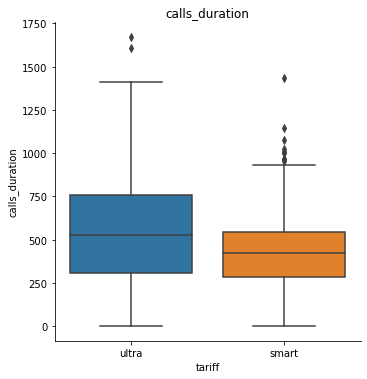

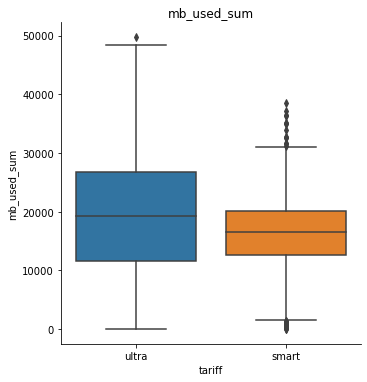

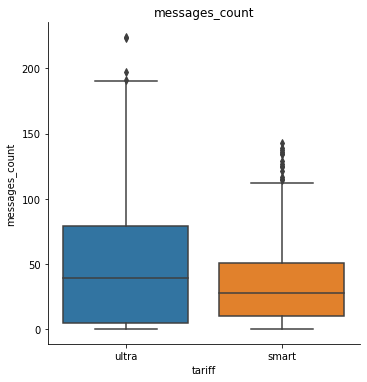

In [85]:
for column in ['calls_duration', 'mb_used_sum', 'messages_count']:
    sns.catplot(x='tariff', y=column, data=users_pivot, kind='box')
    plt.title(column)

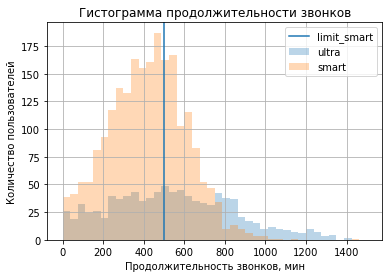

In [86]:
for tariff in ['ultra', 'smart']:   
    users_pivot.query('tariff == @tariff')['calls_duration'].hist(bins=40, range = (0, 1500), alpha=0.3)
plt.axvline(x=tariffs['minutes_included'][0], ymin=0, ymax=1)
plt.legend(['limit_smart', 'ultra', 'smart'])
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность звонков, мин')
plt.title('Гистограмма продолжительности звонков');

Достаточно большое количество пользователей тарифа "Смарт" превышают лимит включенных в тариф минут, но пик использования как раз приходится на количество минут до пятиста.<br>
Пользователи тарифа "Ультра" не выходят за лимит включенных в тариф минут.

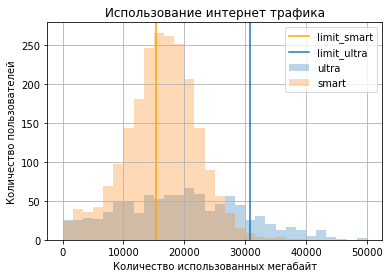

In [87]:
for tariff in ['ultra', 'smart']:
    users_pivot.query('tariff == @tariff')['mb_used_sum'].hist(bins=30, range = (0, 50000), alpha=0.3)
plt.axvline(x=tariffs['mb_per_month_included'][0], ymin=0, ymax=1, color = 'orange')  
plt.axvline(x=tariffs['mb_per_month_included'][1], ymin=0, ymax=1) 
plt.legend(['limit_smart', 'limit_ultra', 'ultra', 'smart'])
plt.ylabel('Количество пользователей')
plt.xlabel('Количество использованных мегабайт')
plt.title('Использование интернет трафика');

Пользователи тарифа "Смарт" чаще пользователей тарифа "Ультра" выходят из лимита включенных в тариф мегабайт. Чаще всего используют примерно от 15000 до 20000 мегабайт.

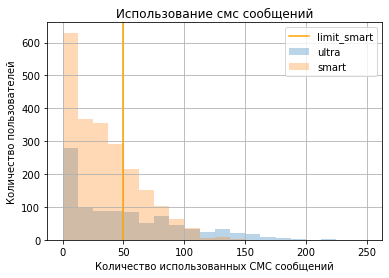

In [88]:
for tariff in ['ultra', 'smart']:
    users_pivot.query('tariff == @tariff')['messages_count'].hist(bins=20, range = (0, 250), alpha=0.3)
plt.axvline(x=tariffs['messages_included'][0], ymin=0, ymax=1, color = 'orange')
plt.legend(['limit_smart', 'ultra', 'smart'])
plt.ylabel('Количество пользователей')
plt.xlabel('Количество использованных СМС сообщений')
plt.title('Использование смс сообщений');

Большая часть пользователей не отправляет сообщения. Пользователи тарифа "Ультра" за лимит не выходят. Некоторым пользователям тарифа "Смарт" приходятся доплачивать сверх тарифа за сообщения.

##### Вывод

Пользователи тарифа "Смарт" часто превышают лимиты по количеству минут и по лимиту мегабайт.
Пользователи тарифов "Смарт" и "Ультра" чаще всего не используют сообщения.
Пользователи тарифа "Ультра" практически не превышают лимитов, кроме мегабайт интернета.
Пользователи тарифа "Ультра" не используют весь лимит по сообщениям и минутам.

##### Проверка гипотез

###### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Для проверки этой гипотезы сначала сформулируем нулевую гипотезу:<br>
H₀ - средняя выручка пользователей тарифа "Смарт" равна выручке пользователей тарифа "Ультра".<br>
Критический уровень статистической значимости = 0.05

In [89]:
ultra = users_pivot.query('tariff == "ultra"')['total_income']
smart = users_pivot.query('tariff == "smart"')['total_income']

alpha = .05

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.155173205867294e-245
Отвергаем нулевую гипотезу


Гипотеза не подтверждена. Можно сказать, что средняя выручка пользователей тарифов  "Смарт" и "Ультра" различаются.

In [90]:
print('Выручка пользователей тарифа "Ультра":',users_pivot.query('tariff == "ultra"')['total_income'].mean())
print('Выручка пользователей тарифа "Смарт":',users_pivot.query('tariff == "smart"')['total_income'].mean())

Выручка пользователей тарифа "Ультра": 2070.9779179810726
Выручка пользователей тарифа "Смарт": 1290.8911381016644


###### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H₀ - средняя выручка пользователей из Москвы равна выручке пользователей из других городов.<br>
Критический уровень статистической значимости = 0.05

In [91]:
moscow = users_pivot.query('city == "Москва"')['total_income'] # пользователи из Москвы
others = moscow = users_pivot.query('city != "Москва"')['total_income'] # пользователи из других городов
alpha = .05

results = st.ttest_ind(
    moscow, 
    others, 
    equal_var=True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


Подтверждаем нулевую гипотезу. Получается, что средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других городов.<br> Посчитаем среднее, чтобы проверить.

In [92]:
print('Выручка пользователей из Москвы:',users_pivot.query('city == "Москва"')['total_income'].mean())
print('Выручка пользователей из других городов:',users_pivot.query('city != "Москва"')['total_income'].mean())

Выручка пользователей из Москвы: 1546.0524590163934
Выручка пользователей из других городов: 1519.5237909516381


In [93]:
users_pivot.groupby('tariff')['total_income'].sum() # суммарная выручка по каждому тарифу

tariff
smart    2869651.0
ultra    1969500.0
Name: total_income, dtype: float64

In [94]:
users.groupby('tariff')['user_id'].count() # количество пользователей тарифа smart и ultra

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

Суммарная выручка по тарифу smart больше, чем по тарифу ultra на 909651 руб. Количество пользователей тарифа smart тоже больше.

# Вывод

Пользователи тарифа "Смарт" чаще выходят за пределы лимитов включенных в тариф минут, мегабайт и смс. Пользователи тарифа  "Смарт" в среднем тратят меньше, чем пользователи тарифа "Ультра". Средняя выручка пользователей тарифа "Ультра" составляет 2070 рублей. Средняя выручка пользователей тарифа "Смарт" составляет 1290 рублей. Однако пользователей тарифа "Смарт" больше и суммарно они приносят больше выручки. 